In [1]:
from bs4 import BeautifulSoup
import requests
from urllib.parse import urlparse, quote
import urllib.request
import os
import pypdf
from collections import deque
import io
import re
from html.parser import HTMLParser
import pandas as pd
from dotenv import load_dotenv
load_dotenv()
import uuid
from langchain import HuggingFaceHub
from langchain.vectorstores import Qdrant
from langchain.embeddings import HuggingFaceEmbeddings
import qdrant_client
from qdrant_client import QdrantClient, models
from langchain.text_splitter import RecursiveCharacterTextSplitter
from httpx import Timeout
from sentence_transformers import SentenceTransformer

c:\Users\NITRO\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To crawl the webpage, I made use of the code mentioned in the OpenAI cookbook: https://github.com/openai/openai-cookbook/blob/main/apps/web-crawl-q-and-a/web-qa.ipynb?ref=mlq.ai

In [7]:


# Regex pattern 
HTTP_URL_PATTERN = r'^http[s]*://.+'

# Define domain
domain = "ashoka.edu.in"
full_url = "https://ashoka.edu.in/"

# Create the class to parse the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        self.hyperlinks = []

    # Overriding the existing functions
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])


def get_hyperlinks(url):

    try:
        with urllib.request.urlopen(url) as response:
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))

def pdf_to_text(pdf_content):
    # Create a PDF file object from the PDF content
    pdf_file = io.BytesIO(pdf_content)

    # Create a PDF reader object
    pdf_reader = pypdf.PdfReader(pdf_file)

    # Extract text from each page of the PDF
    text = ""
    i = 0 
    print(len(pdf_reader.pages))

    for page in range(len(pdf_reader.pages)):
        text += pdf_reader.pages[i].extract_text()
        i=i+1

    return text

def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
        os.mkdir("text/")

    if not os.path.exists("text/" + local_domain + "/"):
        os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
        os.mkdir("processed")

    # Define the header tags to ignore while extracting text
    header_tags = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']

    # While the queue is not empty, continue crawling
    while queue:
        # Get the next URL from the queue
        url = queue.pop()
        print(url)  # for debugging and to see the progress

        response = requests.get(url)

        # Sanitize the URL to create a valid filename
        sanitized_url = quote(url, safe='')

        # Save text from the URL to a <url>.txt file
        with open('text/' + local_domain + '/' + sanitized_url + ".txt", "w", encoding="utf-8") as f:
            # Get the text from the URL using BeautifulSoup
            if response.headers.get('Content-Type') == ("application/pdf"):
                pdf_text = pdf_to_text(response.content)
                f.write(pdf_text)
            else:
                soup = BeautifulSoup(requests.get(url).text, "html.parser")

                # Remove header tags and anchor tags with titles from the soup object
                for tag in soup.find_all(header_tags):
                    tag.extract()
                for tag in soup.find_all('a', {'title': True}):
                    tag.extract()

                # Remove the text content within anchor tags but keep the anchor tags
                for tag in soup.find_all('a'):
                    tag.string = ''  # Set the text content within anchor tags to an empty string

                # Get the text from the soup object but preserve the text within span tags
                text = ""
                for tag in soup.find_all(string=True):
                    if tag.parent.name != 'span':
                        text += tag



                # Get the text but remove the remaining tags
                text = soup.get_text()

                # If the crawler gets to a page that requires JavaScript, it will stop the crawl
                if "You need to enable JavaScript to run this app." in text:
                    print("Unable to parse page " + url + " due to JavaScript being required")

                # Otherwise, write the text to the file in the text directory
                f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

crawl(full_url)



https://ashoka.edu.in/
https://ashoka.edu.in/roles/leadership-team/?filterby=320
https://ashoka.edu.in/javascript:;
HTTP Error 404: Not Found
https://ashoka.edu.in/roles/founders/?filterby=2198
https://ashoka.edu.in/events
https://ashoka.edu.in/roles/founders/?filterby=2200
https://ashoka.edu.in/placements
https://ashoka.edu.in/placement-internships
https://ashoka.edu.in/campus-life
https://ashoka.edu.in/campus-student-life
https://ashoka.edu.in/student-affairs
https://ashoka.edu.in/sports-exercise
https://ashoka.edu.in/campus-facilities
https://ashoka.edu.in/campus-residence-life
https://ashoka.edu.in/clubs-and-societies
https://ashoka.edu.in/../tag/clubsocity
HTTP Error 400: Bad Request
https://ashoka.edu.in/roles/leadership-team/?filterby=2180
https://ashoka.edu.in/roles/leadership-team/?filterby=319
https://ashoka.edu.in/roles/founders/?filterby=2195
https://ashoka.edu.in/ashoka-for-parents
https://ashoka.edu.in/faqs-parents
https://ashoka.edu.in/academic-calendar
https://ashoka.ed

In [2]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [3]:
texts = []

for file in os.listdir("text/ashoka.edu.in/"):
    with open("text/ashoka.edu.in/" + file, "r" , encoding="utf-8") as f:
        text = f.read()
        texts.append(text)

df = pd.DataFrame(texts, columns = ['text'])
df['text'] = remove_newlines(df.text)
df['id'] = [uuid.uuid4() for _ in range(len(df))]
df.to_csv('processed/scraped.csv', escapechar="\\")
df.head()



C:\Users\NITRO\AppData\Local\Temp\ipykernel_888\2931785837.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,text,id
0,Chemistry Handbook GUIDELINES FOR STUDENTS ...,700df7d2-23e6-4ade-b5b9-d329ae8bffa7
1,1 POLITICAL SCIENCE HANDBOOK GUIDELINES F...,9bd7edf9-d966-489b-82e4-0edb8a64a41c
2,Chemistry Handbook GUIDELINES FOR STUDENTS ...,d4a2d426-0397-4602-9f54-4547e276b4e6
3,Department of BIOLOGICAL SCIENCESDepartment of...,0351c91e-9925-4e46-b6b5-1d909570ca87
4,Students’ Guide Department of Computer Science...,1e85fd11-c526-45af-82d7-bbf4db65d279


<Axes: >

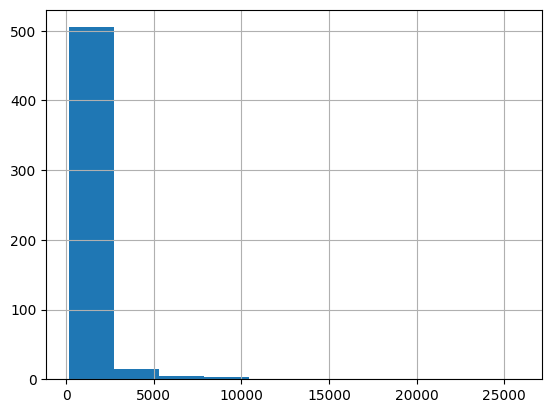

In [4]:
import tiktoken
tokenizer = tiktoken.get_encoding("cl100k_base")
df = pd.read_csv("processed/scraped.csv", index_col= 0)
df.columns = ['text', 'id']
df = df[pd.notna(df['text'])]
df['no_tokens'] = df.text.apply(lambda x : len(tokenizer.encode(x)))
df['no_tokens'].hist()

In [6]:
client = qdrant_client.QdrantClient(
    url=os.getenv('QDRANT_HOST'),
    api_key=os.getenv('QDRANT_API_KEY'),
    timeout=Timeout(timeout=None)
)

client.recreate_collection(
    collection_name='first',
    vectors_config=models.VectorParams(size = 384, distance=models.Distance.COSINE),
    optimizers_config=models.OptimizersConfigDiff(
        indexing_threshold=0,
    ),
    shard_number=2,

)

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vector_store = Qdrant(client=client, collection_name='first',embeddings=embeddings,)

In [10]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=20,
    length_function=len,
    separators=["\n\n", "\n", " ", ""]
)

chunks = text_splitter.split_text(df['text'])

# Define the size of each batch
batch_size = 1000  # Adjust this value based on your data

# Split the chunks into batches
batches = [chunks[i:i + batch_size] for i in range(0, len(chunks), batch_size)]

# Upload each batch
for i, batch in enumerate(batches):
    try:
        print(f"Uploading batch {i+1} of {len(batches)}")
        vector_store.add_texts(batch)
    except Exception as e:
        print(f"Error uploading batch {i+1}: {e}")

    

Uploading batch 1 of 6
Uploading batch 2 of 6
Uploading batch 3 of 6
Uploading batch 4 of 6
Uploading batch 5 of 6
Uploading batch 6 of 6


In [11]:
client.update_collection(
    collection_name="first",
    optimizer_config=models.OptimizersConfigDiff(
        indexing_threshold=20000
    )
)

True

In [5]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
client = qdrant_client.QdrantClient(
    url=os.getenv('QDRANT_HOST'),
    api_key=os.getenv('QDRANT_API_KEY'),
    timeout=Timeout(timeout=None)
)

doc_store = Qdrant(client=client,
    collection_name = "first",
    embeddings = embeddings)

In [6]:
#example
encoder = SentenceTransformer('all-MiniLM-L6-v2') 
hits = client.search(
	collection_name="first",
	query_vector=encoder.encode("computer science interdisciplinary").tolist(),
	limit=3
)
for hit in hits:
	print(hit.payload, "score:", hit.score)


{'metadata': None, 'page_content': 'areas like computational biology, social and information networks, digital humanities and data-driven journalism. 2 interdisciplinary majors, a minor, a concentration are also offered by the Department in addition to an undergraduate major in Computer Science and a Ph.D. in Computer Science. The goals of the programme include (but are not limited to): 1.Impart a deep understanding of the'} score: 0.6239994
{'metadata': None, 'page_content': 'understanding of the foundations of Computer Science 2.Enable a student to be able to systematically apply the foundational knowledge across disci- plines 3.Create new knowledge in the ﬁeld of Computer Science 1.3.1 Programs Offered •Undergraduate –Major –Interdisciplinary Major –Advanced Major–Minor –Concentration •PhD •Graduate Assistantship 1.3.2 Faculty and Research Interests •Ravi Kothari ,'} score: 0.6151194
{'metadata': None, 'page_content': 'more on this, please refer to the section on Awards and Recognit

In [ ]:
from langchain.agents import ZeroShotAgent, Tool, AgentExecutor
from langchain import OpenAI, SerpAPIWrapper, LLMChain
from langchain.chains import RetrievalQA
llm = OpenAI(temperature=0)
helper = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type='stuff',
    retriever = doc_store.as_retriever(),
)
search = SerpAPIWrapper()
tools = [
    Tool(
        name="Ashoka_dataqa",
        func=helper.run,
        description='This function should be called whenever there is a question about the past events in ashoka, or those events that are supposed to be like what is mentioned in the database for a while.Some examples could be questions about courses, faculties etc.'
    ),
    Tool(
        name ="search",
        func=search.run,
        description="This tool must only be used if the context obtained from vectorstore is not enough to answer the question . useful for when you need to answer questions about upcoming and real time events/informations about ashoka university."
    )
]
prefix = """Answer the following questions as best you can, but speak only if you have enough data. You have access to the following tools:"""
suffix = """Begin! Remember to not make up things, if you do not know the answer, say "I dont know"

Question: {input}
{agent_scratchpad}"""

prompt = ZeroShotAgent.create_prompt(
    tools, prefix=prefix, suffix=suffix, input_variables=["input", "agent_scratchpad"]
)
llm_chain = LLMChain(llm=llm, prompt=prompt)
tool_names = [tool.name for tool in tools]
agent = ZeroShotAgent(llm_chain=llm_chain, allowed_tools=tool_names)
agent_executor = AgentExecutor.from_agent_and_tools(
    agent=agent, tools=tools, verbose=True)
agent_executor.run("What is the current controversy in ashoka?")